In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
from xtquant import xtdatacenter as xtdc
xtdc.set_token("26e6009f4de3bfb2ae4b89763f255300e96d6912")

print('xtdc.init')
xtdc.init() # 初始化行情模块，加载合约数据，会需要大约十几秒的时间
print('done')

from xtquant import xtdata 

xtdc.init
done


In [ ]:
hd_pct = 0.001

params = [
           {
            'filtered': True,
            'fx_filtered': True,
            'topn': 1,
            'top_fx': 3,
            'top_cx': 2,
            'only_fx': False,
            'enbale_industry': False,
            'empty_priority': False
            }
        ]

In [4]:
def get_real_open_price(stock_code, datekey):
    import datetime

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 29, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 30, 5)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.head(1)

    last_price = min_time_row['lastPrice']

    # 检查 Series 是否只有一个元素
    if len(last_price) == 1:
        last_price_real = last_price.item()
    else:
        raise Exception(f"{stock_code}-{datekey}")

    return last_price_real

In [5]:
def group_filter_fx(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False):
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()
            
            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row

            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == 1].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            else:
                category_filtered = group[(group['max_block_category_rank'] <= top_fx) & ((group['max_block_code_rank'] <= top_cx) | (group['max_industry_code_rank'] <= top_cx))]
                if len(category_filtered) == 0:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == 1].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row

                result = category_filtered[category_filtered['max_block_code_rank'] == category_filtered['max_block_code_rank'].min()]
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row



def group_filter(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False):
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()

            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            
            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == 1].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            elif min_category_rank < 0:
                category_filtered = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                if not category_filtered.empty and len(category_filtered) > 0:
                    category_filtered = category_filtered[category_filtered['stock_rank'] == category_filtered['stock_rank'].min()]
                    category_filtered['return'] = category_filtered['next_day_open_price'] / category_filtered['open_price'] - 1
                    category_filtered['real_return'] = category_filtered['return'] - hd_pct
                    category_filtered['close_return'] = category_filtered['next_day_close_price'] / category_filtered['open_price'] - 1
                    category_filtered['close_real_return'] = category_filtered['close_return'] - hd_pct
                    return category_filtered
                else:
                    rank_one_row = group[group['max_block_category_rank'] == min_category_rank]
                    if len(rank_one_row) > 0:
                        rank_one_row = rank_one_row[rank_one_row['stock_rank'] == rank_one_row['stock_rank'].min()].copy()
                        if not rank_one_row.empty and len(rank_one_row) > 0:
                            rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                            rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                            return rank_one_row
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == 1].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                    else:
                        raise Exception("No data.")
            else:
                result = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                
                if result.empty or len(result) < 1:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == 1].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row


In [6]:
param0 = params[0]
empty_priority = param0['empty_priority']
del param0['empty_priority']
if empty_priority:
    filter_func = group_filter_fx
else:
    filter_func = group_filter

In [7]:
import sqlite3
# months = ['202502']
months = ['202409', '202410', '202411', '202412', '202501', '202502' ]
# months = ['202409', '202410']
combined_df = pd.DataFrame()
for month in months:
    conn = sqlite3.connect('D:\workspace\TradeX\ezMoney\sqlite_db\strategy_data.db')
    db_name = 'strategy_data_aftermarket_%s' % month
    query = "select * from %s where (strategy_name = 'xiao_cao_1j2db') and stock_rank <= 3 " % db_name
    df = pd.read_sql_query(query, conn)
    combined_df = pd.concat([combined_df, df], axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,...,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,block_category_info,created_at
0,2094,2024-09-03,xiao_cao_1j2db,,603004.XSHG,鼎龙科技,1,"000036.BKDL,000026.BKDL,000022.BKDL,000032.BKD...","885840.DDBK,885598.DDBK,885929.DDBK,885905.DDB...",980364.ZHBK,...,,-100.0,-100.0,-1,-100.0,-100.0,-1,"{""9A0001"": {""realShortLineScore"": 20.72, ""real...","{""000028.BKDL"": {""categoryCode"": ""000028.BKDL""...",2025-03-02 10:22:43
1,2095,2024-09-06,xiao_cao_1j2db,,603207.XSHG,小方制药,1,,,980378.ZHBK,...,,-100.0,-100.0,-1,-100.0,-100.0,-1,"{""9A0001"": {""realShortLineScore"": -22.6, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-03-02 10:22:51
2,2096,2024-09-25,xiao_cao_1j2db,,002513.XSHE,蓝丰生化,1,"000026.BKDL,000024.BKDL,000023.BKDL,000035.BKD...","885840.DDBK,885505.DDBK,885802.DDBK,885633.DDB...",980364.ZHBK,...,,-100.0,-100.0,-1,-100.0,-100.0,-1,"{""9A0001"": {""realShortLineScore"": 77.46, ""real...","{""000015.BKDL"": {""categoryCode"": ""000015.BKDL""...",2025-03-02 10:23:13
3,2097,2024-09-27,xiao_cao_1j2db,,600838.XSHG,上海九百,1,"000012.BKDL,000023.BKDL,000010.BKDL,000015.BKD...","885869.DDBK,885788.DDBK,885620.DDBK,886021.DDB...","980374.ZHBK,980345.ZHBK",...,,-100.0,-100.0,-1,-100.0,-100.0,-1,"{""9A0001"": {""realShortLineScore"": 104.45, ""rea...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-02 10:23:19
4,1619,2024-10-11,xiao_cao_1j2db,,603052.XSHG,可川科技,1,"000035.BKDL,000031.BKDL,000027.BKDL,000032.BKD...","886033.DDBK,885598.DDBK,885906.DDBK,885710.DDB...",980357.ZHBK,...,,-100.0,-100.0,-1,-100.0,-100.0,-1,"{""9A0001"": {""realShortLineScore"": 110.58, ""rea...","{""000023.BKDL"": {""categoryCode"": ""000023.BKDL""...",2025-03-02 10:23:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,3674,2025-02-27,xiao_cao_1j2db,,001380.XSHE,华纬科技,1,"000027.BKDL,000032.BKDL,000033.BKDL","885598.DDBK,885517.DDBK,885834.DDBK,885929.DDB...",980372.ZHBK,...,,-100.0,-100.0,-1,-100.0,-100.0,-1,"{""9A0001"": {""realShortLineScore"": 43.12, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-03-02 10:27:05
83,3675,2025-02-27,xiao_cao_1j2db,,002654.XSHE,万润科技,2,"000012.BKDL,000008.BKDL,000023.BKDL,000019.BKD...","886042.DDBK,885875.DDBK,885861.DDBK,885517.DDB...","980353.ZHBK,980357.ZHBK,980355.ZHBK",...,,-100.0,-100.0,-1,-100.0,-100.0,-1,"{""9A0001"": {""realShortLineScore"": 43.12, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-03-02 10:27:05
84,3681,2025-02-28,xiao_cao_1j2db,,002042.XSHE,华孚时尚,1,,,,...,,-100.0,-100.0,-1,-100.0,-100.0,-1,"{""9A0001"": {""realShortLineScore"": -20.48, ""rea...","{""000033.BKDL"": {""categoryCode"": ""000033.BKDL""...",2025-03-03 08:00:18
85,3682,2025-02-28,xiao_cao_1j2db,,603777.XSHG,来伊份,2,"000012.BKDL,000018.BKDL,000010.BKDL,000037.BKD...","885520.DDBK,885420.DDBK,885525.DDBK,885779.DDB...",980345.ZHBK,...,,-100.0,-100.0,-1,-100.0,-100.0,-1,"{""9A0001"": {""realShortLineScore"": -20.48, ""rea...","{""000033.BKDL"": {""categoryCode"": ""000033.BKDL""...",2025-03-03 08:00:18


In [8]:
combined_df = combined_df.drop(['env_json_info', 'block_category_info'], axis=1)
combined_df = combined_df[combined_df['strategy_name'] == 'xiao_cao_1j2db']
combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)

# 将索引设置为 date_key 列
combined_df = combined_df.set_index('date_key')

# 对索引进行排序
combined_df = combined_df.sort_index()


combined_df

C:\Users\Administrator\AppData\Local\Temp\ipykernel_31088\2112515499.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)


,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,...,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,return,real_return,close_return,close_real_return
date_key,,,,,,,,,,,,,,,,,,,,,
2024-09-06,2095,xiao_cao_1j2db,,603207.XSHG,小方制药,1,,,980378.ZHBK,-1,...,-100.0,-1,-100.0,-100.0,-1,2025-03-02 10:22:51,-0.061324,-0.062324,-0.101580,-0.102580
2024-09-27,2097,xiao_cao_1j2db,,600838.XSHG,上海九百,1,"000012.BKDL,000023.BKDL,000010.BKDL,000015.BKD...","885869.DDBK,885788.DDBK,885620.DDBK,886021.DDB...","980374.ZHBK,980345.ZHBK",3,...,-100.0,-1,-100.0,-100.0,-1,2025-03-02 10:23:19,-0.025882,-0.026882,0.038824,0.037824
2024-10-11,1619,xiao_cao_1j2db,,603052.XSHG,可川科技,1,"000035.BKDL,000031.BKDL,000027.BKDL,000032.BKD...","886033.DDBK,885598.DDBK,885906.DDBK,885710.DDB...",980357.ZHBK,3,...,-100.0,-1,-100.0,-100.0,-1,2025-03-02 10:23:29,-0.099595,-0.100595,-0.014035,-0.015035
2024-10-16,1620,xiao_cao_1j2db,,600807.XSHG,济高发展,1,"000024.BKDL,000007.BKDL,000009.BKDL,000001.BKD...","886021.DDBK,885917.DDBK,885530.DDBK,885994.DDB...","980378.ZHBK,980358.ZHBK",1,...,-100.0,-1,-100.0,-100.0,-1,2025-03-02 10:23:37,0.006024,0.005024,-0.024096,-0.025096
2024-10-17,1622,xiao_cao_1j2db,,603106.XSHG,恒银科技,1,"000012.BKDL,000003.BKDL,000014.BKDL,000018.BKD...","885757.DDBK,885487.DDBK,886019.DDBK,885759.DDB...",980366.ZHBK,2,...,-100.0,-1,-100.0,-100.0,-1,2025-03-02 10:23:39,-0.094444,-0.095444,-0.015556,-0.016556
2024-10-21,1624,xiao_cao_1j2db,,002583.XSHE,海能达,1,"000008.BKDL,000026.BKDL,000018.BKDL,000023.BKD...","885840.DDBK,885757.DDBK,885521.DDBK,885574.DDB...",980376.ZHBK,2,...,-100.0,-1,-100.0,-100.0,-1,2025-03-02 10:23:43,0.166667,0.165667,0.205833,0.204833
2024-10-24,1626,xiao_cao_1j2db,,002514.XSHE,宝馨科技,1,"000038.BKDL,000035.BKDL,000023.BKDL,000018.BKD...","885878.DDBK,885739.DDBK,885930.DDBK,885517.DDB...",980365.ZHBK,1,...,-100.0,-1,-100.0,-100.0,-1,2025-03-02 10:23:51,0.060606,0.059606,0.166667,0.165667
2024-10-28,1629,xiao_cao_1j2db,,603978.XSHG,深圳新星,1,,,,-1,...,-100.0,-1,-100.0,-100.0,-1,2025-03-02 10:23:54,-0.047396,-0.048396,-0.084896,-0.085896
2024-10-30,1630,xiao_cao_1j2db,,002423.XSHE,中粮资本,1,"000038.BKDL,000023.BKDL,000010.BKDL,000015.BKD...","885869.DDBK,886021.DDBK,885694.DDBK,885741.DDB...","980360.ZHBK,980341.ZHBK",3,...,-100.0,-1,-100.0,-100.0,-1,2025-03-02 10:23:58,0.116255,0.115255,0.130984,0.129984


In [9]:
from xtquant import xtdata
import time
import pandas as pd

all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock
for i in range(1, 11):
    combined_df[f'close_{i}'] = -1
    combined_df[f'low_{i}'] = -1
combined_df['real_open'] = -1
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    n_data_key = date_key
    if '-' in n_data_key:
        n_data_key = n_data_key.replace('-', '')
    xtdata.download_history_data(stock_code, '1m', n_data_key, n_data_key)
    all_data = xtdata.get_market_data(stock_list=[stock_code], period='1m', start_time=n_data_key, end_time=n_data_key)

    df = pd.DataFrame()
    for key in all_data.keys():
        ndf = all_data[key].T
        ndf = ndf.sort_index()
        ndf.columns = [key]
        df = pd.concat([df, ndf], axis=1)
    
    i = 1
    for idx, rrow in df[1:11].iterrows():
        combined_df.loc[date_key, f'close_{i}'] = rrow['close']
        combined_df.loc[date_key, f'low_{i}'] = rrow['low']
        i += 1
    real_open_price = get_real_open_price(stock_code, date_key)
    combined_df.loc[date_key, 'real_open'] = real_open_price

***** xtdata连接成功 *****
服务信息: {'tag': 'xtquant', 'version': '1.0'}
服务地址: 127.0.0.1:58609
数据路径: d:\workspace\TradeX\notebook\data\datadir
设置xtdata.enable_hello = False可隐藏此消息



C:\Users\Administrator\AppData\Local\Temp\ipykernel_31088\498375655.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '27.27' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, f'close_{i}'] = rrow['close']
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31088\498375655.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '26.51' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, f'low_{i}'] = rrow['low']
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31088\498375655.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '27.21' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

In [10]:
combined_df['r_return'] = combined_df['next_day_close_price']/combined_df['real_open'] - 1

In [11]:
combined_df

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,...,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return
date_key,,,,,,,,,,,,,,,,,,,,,
2024-09-06,2095,xiao_cao_1j2db,,603207.XSHG,小方制药,1,,,980378.ZHBK,-1,...,28.50,28.36,28.10,28.05,28.30,28.02,28.41,28.19,26.56,-0.100904
2024-09-27,2097,xiao_cao_1j2db,,600838.XSHG,上海九百,1,"000012.BKDL,000023.BKDL,000010.BKDL,000015.BKD...","885869.DDBK,885788.DDBK,885620.DDBK,886021.DDB...","980374.ZHBK,980345.ZHBK",3,...,8.43,8.43,8.36,8.35,8.42,8.35,8.44,8.42,8.54,0.033958
2024-10-11,1619,xiao_cao_1j2db,,603052.XSHG,可川科技,1,"000035.BKDL,000031.BKDL,000027.BKDL,000032.BKD...","886033.DDBK,885598.DDBK,885906.DDBK,885710.DDB...",980357.ZHBK,3,...,37.00,36.33,37.02,37.00,36.62,36.60,36.56,36.51,37.20,-0.018011
2024-10-16,1620,xiao_cao_1j2db,,600807.XSHG,济高发展,1,"000024.BKDL,000007.BKDL,000009.BKDL,000001.BKD...","886021.DDBK,885917.DDBK,885530.DDBK,885994.DDB...","980378.ZHBK,980358.ZHBK",1,...,3.30,3.29,3.29,3.29,3.25,3.25,3.30,3.24,3.34,-0.029940
2024-10-17,1622,xiao_cao_1j2db,,603106.XSHG,恒银科技,1,"000012.BKDL,000003.BKDL,000014.BKDL,000018.BKD...","885757.DDBK,885487.DDBK,886019.DDBK,885759.DDB...",980366.ZHBK,2,...,8.63,8.60,8.59,8.59,8.60,8.55,8.56,8.56,9.03,-0.018826
2024-10-21,1624,xiao_cao_1j2db,,002583.XSHE,海能达,1,"000008.BKDL,000026.BKDL,000018.BKDL,000023.BKD...","885840.DDBK,885757.DDBK,885521.DDBK,885574.DDB...",980376.ZHBK,2,...,12.69,12.67,12.69,12.61,12.90,12.69,13.03,12.89,12.00,0.205833
2024-10-24,1626,xiao_cao_1j2db,,002514.XSHE,宝馨科技,1,"000038.BKDL,000035.BKDL,000023.BKDL,000018.BKD...","885878.DDBK,885739.DDBK,885930.DDBK,885517.DDB...",980365.ZHBK,1,...,6.99,6.86,6.99,6.99,6.97,6.96,6.87,6.86,6.60,0.166667
2024-10-28,1629,xiao_cao_1j2db,,603978.XSHG,深圳新星,1,,,,-1,...,18.60,18.42,19.01,18.50,19.08,19.01,19.45,19.05,19.20,-0.084896
2024-10-30,1630,xiao_cao_1j2db,,002423.XSHE,中粮资本,1,"000038.BKDL,000023.BKDL,000010.BKDL,000015.BKD...","885869.DDBK,886021.DDBK,885694.DDBK,885741.DDB...","980360.ZHBK,980341.ZHBK",3,...,18.50,18.50,18.86,18.30,18.10,18.10,18.46,18.01,19.11,0.125065


In [12]:
combined_df[['open_price', 'next_day_close_price', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10']]

,open_price,next_day_close_price,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10
date_key,,,,,,,,,,,,
2024-09-06,26.58,23.88,26.51,27.21,27.69,27.80,28.00,28.40,28.36,28.05,28.02,28.19
2024-09-27,8.50,8.83,8.54,8.51,8.50,8.32,8.35,8.37,8.43,8.35,8.35,8.42
2024-10-11,37.05,36.53,37.20,37.23,37.21,37.22,37.07,36.50,36.33,37.00,36.60,36.51
2024-10-16,3.32,3.24,3.30,3.33,3.30,3.28,3.29,3.30,3.29,3.29,3.25,3.24
2024-10-17,9.00,8.86,9.02,8.66,8.20,8.35,8.45,8.52,8.60,8.59,8.55,8.56
2024-10-21,12.00,14.47,11.95,12.51,12.51,12.49,12.51,12.60,12.67,12.61,12.69,12.89
2024-10-24,6.60,7.70,6.51,6.68,6.82,6.83,6.83,6.93,6.86,6.99,6.96,6.86
2024-10-28,19.20,17.57,19.19,19.37,18.88,18.31,18.63,18.70,18.42,18.50,19.01,19.05
2024-10-30,19.01,21.50,19.11,19.50,19.02,19.23,19.27,19.12,18.50,18.30,18.10,18.01


In [13]:
# combined_df['avg_close'] = 0
# for i in range(1, 11):
#     combined_df['avg_close'] += combined_df['close_%s' % i]
# combined_df['avg_close'] = combined_df['avg_close'] / 10
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx

In [14]:
def caculate_returns(returns_df, row, _print = False):
    r = {}
    cumulative_returns = (1 + returns_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (returns_df[row].mean() - risk_free_rate) / returns_df[row].std()

    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = returns_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] =  max_drawdown
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r

In [15]:

ddwndx['r_return'] = ddwndx['next_day_close_price']/ddwndx['real_open'] - 1
ddwndx['r_return'] = ddwndx['r_return']-0.001
ddwndx['cumulative_returns'] = (1 + ddwndx['r_return']).cumprod()
print("return:")
caculate_returns(ddwndx, 'r_return', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -30.02%
夏普比率: 0.13
总收益率: 37.63%
年化收益率: 225.80%
波动率: 9.73%
总盈亏: 47.82%
成功次数: 20
失败次数: 20
总天数: 40
总交易次数: 40
交易频率: 100.00%
胜率: 50.00%
平均盈利: 9.09%
平均亏损: -6.57%
最大盈利: 20.48%
最大亏损: -22.04%
盈亏比: 1.38
凯利公式最佳仓位: 13.88%
-----------------------------------------------------


In [16]:
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,...,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,
2024-09-06,2095,xiao_cao_1j2db,,603207.XSHG,小方制药,1,,,980378.ZHBK,-1,...,28.36,28.10,28.05,28.30,28.02,28.41,28.19,26.56,-0.101904,0.898096
2024-09-27,2097,xiao_cao_1j2db,,600838.XSHG,上海九百,1,"000012.BKDL,000023.BKDL,000010.BKDL,000015.BKD...","885869.DDBK,885788.DDBK,885620.DDBK,886021.DDB...","980374.ZHBK,980345.ZHBK",3,...,8.43,8.36,8.35,8.42,8.35,8.44,8.42,8.54,0.032958,0.927696
2024-10-11,1619,xiao_cao_1j2db,,603052.XSHG,可川科技,1,"000035.BKDL,000031.BKDL,000027.BKDL,000032.BKD...","886033.DDBK,885598.DDBK,885906.DDBK,885710.DDB...",980357.ZHBK,3,...,36.33,37.02,37.00,36.62,36.60,36.56,36.51,37.20,-0.019011,0.910060
2024-10-16,1620,xiao_cao_1j2db,,600807.XSHG,济高发展,1,"000024.BKDL,000007.BKDL,000009.BKDL,000001.BKD...","886021.DDBK,885917.DDBK,885530.DDBK,885994.DDB...","980378.ZHBK,980358.ZHBK",1,...,3.29,3.29,3.29,3.25,3.25,3.30,3.24,3.34,-0.030940,0.881902
2024-10-17,1622,xiao_cao_1j2db,,603106.XSHG,恒银科技,1,"000012.BKDL,000003.BKDL,000014.BKDL,000018.BKD...","885757.DDBK,885487.DDBK,886019.DDBK,885759.DDB...",980366.ZHBK,2,...,8.60,8.59,8.59,8.60,8.55,8.56,8.56,9.03,-0.019826,0.864417
2024-10-21,1624,xiao_cao_1j2db,,002583.XSHE,海能达,1,"000008.BKDL,000026.BKDL,000018.BKDL,000023.BKD...","885840.DDBK,885757.DDBK,885521.DDBK,885574.DDB...",980376.ZHBK,2,...,12.67,12.69,12.61,12.90,12.69,13.03,12.89,12.00,0.204833,1.041479
2024-10-24,1626,xiao_cao_1j2db,,002514.XSHE,宝馨科技,1,"000038.BKDL,000035.BKDL,000023.BKDL,000018.BKD...","885878.DDBK,885739.DDBK,885930.DDBK,885517.DDB...",980365.ZHBK,1,...,6.86,6.99,6.99,6.97,6.96,6.87,6.86,6.60,0.165667,1.214017
2024-10-28,1629,xiao_cao_1j2db,,603978.XSHG,深圳新星,1,,,,-1,...,18.42,19.01,18.50,19.08,19.01,19.45,19.05,19.20,-0.085896,1.109738
2024-10-30,1630,xiao_cao_1j2db,,002423.XSHE,中粮资本,1,"000038.BKDL,000023.BKDL,000010.BKDL,000015.BKD...","885869.DDBK,886021.DDBK,885694.DDBK,885741.DDB...","980360.ZHBK,980341.ZHBK",3,...,18.50,18.86,18.30,18.10,18.10,18.46,18.01,19.11,0.124065,1.247418


In [17]:
# ddwndx['real_return'] = ddwndx['next_day_close_price']/ddwndx['open_price'] - 1 - 0.003
# ddwndx['cumulative_returns'] = (1 + ddwndx['real_return']).cumprod()
# print("return:")
# caculate_returns(ddwndx, 'real_return', _print=True)
# print('-----------------------------------------------------')

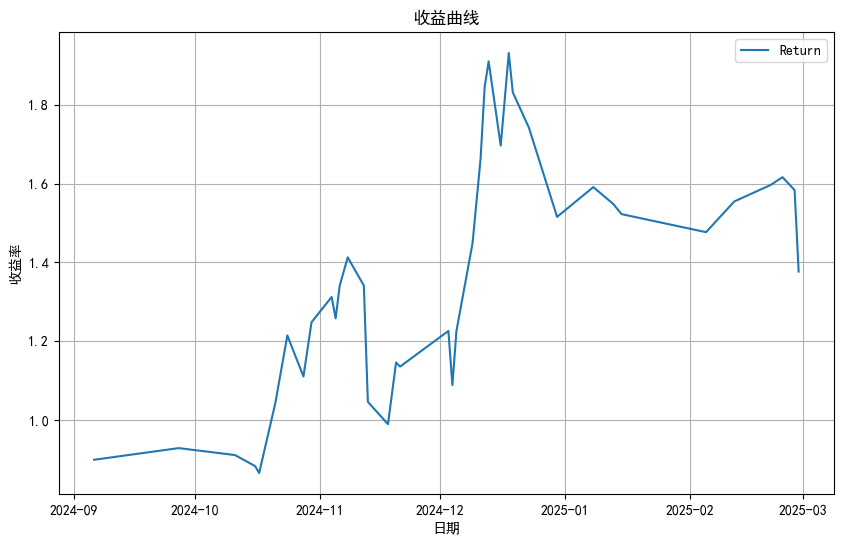

In [18]:
plot(ddwndx, 'cumulative_returns')

In [19]:
ddwndx['r_pct'] = ddwndx['real_open']/ddwndx['open_price']

In [20]:
pd.set_option('display.max_columns', None)
ddwndx.sort_values(by='r_pct', ascending=False)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns,r_pct
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-05,2785,xiao_cao_1j2db,,002593.XSHE,日上集团,1,"000026.BKDL,000023.BKDL,000018.BKDL,000006.BKD...","885617.DDBK,885869.DDBK,885312.DDBK,885806.DDB...",980338.ZHBK,1,1,43,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,337.67,0.0,774.77,0.0,3.51,5.31,5.64,-1.0,6.20,6.20,-1.0,-1.0,-1.0,-1.0,0,0,,,-100.0,-100.0,-1,-100.0,-100.0,-1,2025-03-02 10:25:04,0.167608,0.166608,0.167608,0.166608,5.64,5.50,5.64,5.64,5.64,5.64,5.64,5.64,5.64,5.64,5.64,5.64,5.64,5.64,5.64,5.64,5.64,5.64,5.64,5.64,5.50,0.126273,1.225380,1.035782
2024-12-30,2804,xiao_cao_1j2db,,002364.XSHE,中恒电气,1,"000012.BKDL,000003.BKDL,000026.BKDL,000035.BKD...","885701.DDBK,885571.DDBK,885425.DDBK,885461.DDB...",980474.ZHBK,1,1,28,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,185.97,0.0,423.36,0.0,4.44,11.99,11.50,-1.0,12.05,10.79,-1.0,-1.0,-1.0,-1.0,0,0,,,-100.0,-100.0,-1,-100.0,-100.0,-1,2025-03-02 10:25:41,0.005004,0.004004,-0.100083,-0.101083,12.63,11.96,12.63,12.63,12.63,12.63,12.63,12.63,12.63,12.63,12.63,12.63,12.63,12.63,12.63,12.63,12.63,12.63,12.63,12.63,12.39,-0.130136,1.515318,1.033361
2024-12-19,2798,xiao_cao_1j2db,,000759.XSHE,中百集团,1,"000012.BKDL,000024.BKDL,000026.BKDL,000018.BKD...","885951.DDBK,886021.DDBK,885812.DDBK,885901.DDB...","980374.ZHBK,980345.ZHBK",1,1,29,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,69.05,0.0,510.60,0.0,1.18,8.61,9.36,-1.0,8.42,8.42,-1.0,-1.0,-1.0,-1.0,0,0,,,-100.0,-100.0,-1,-100.0,-100.0,-1,2025-03-02 10:25:25,-0.022067,-0.023067,-0.022067,-0.023067,8.92,8.87,9.20,8.93,9.21,9.16,9.30,9.13,9.17,9.17,9.30,9.08,9.23,9.23,9.28,9.19,9.25,9.25,9.33,9.16,8.87,-0.051733,1.831775,1.030197
2025-02-21,3669,xiao_cao_1j2db,,002272.XSHE,川润股份,1,"000035.BKDL,000023.BKDL,000011.BKDL,000006.BKD...","885571.DDBK,885996.DDBK,885425.DDBK,885854.DDB...","980365.ZHBK,980474.ZHBK",1,2,22,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,78.60,0.0,325.13,0.0,2.28,11.22,12.07,-1.0,12.07,11.80,-1.0,-1.0,-1.0,-1.0,0,0,,,-100.0,-100.0,-1,-100.0,-100.0,-1,2025-03-02 10:26:53,0.075758,0.074758,0.051693,0.050693,11.45,11.28,11.36,11.32,11.32,11.30,11.27,11.27,11.37,11.28,11.32,11.32,11.58,11.37,11.45,11.45,11.41,11.40,11.52,11.40,11.48,0.026875,1.596187,1.023173
2024-12-23,2803,xiao_cao_1j2db,,603657.XSHG,春光科技,1,,,,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,37.96,0.0,333.65,0.0,2.88,17.16,16.97,-1.0,17.02,16.66,-1.0,-1.0,-1.0,-1.0,0,0,,,-100.0,-100.0,-1,-100.0,-100.0,-1,2025-03-02 10:25:29,-0.008159,-0.009159,-0.029138,-0.030138,17.68,17.00,17.25,17.23,17.38,17.27,17.26,17.25,17.19,17.18,17.20,17.19,17.19,17.18,17.16,17.16,17.06,17.03,17.11,17.07,17.50,-0.049000,1.742018,1.019814
2024-11-05,2703,xiao_cao_1j2db,,603275.XSHG,众辰科技,1,"000035.BKDL,000027.BKDL,000032.BKDL,000025.BKD...","885312.DDBK,885641.DDBK,885598.DDBK,885517.DDB...",980365.ZHBK,1,2,12,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,53.66,0.0,461.87,0.0,2.94,34.00,33.66,-1.0,33.67,33.2

<Axes: ylabel='Frequency'>

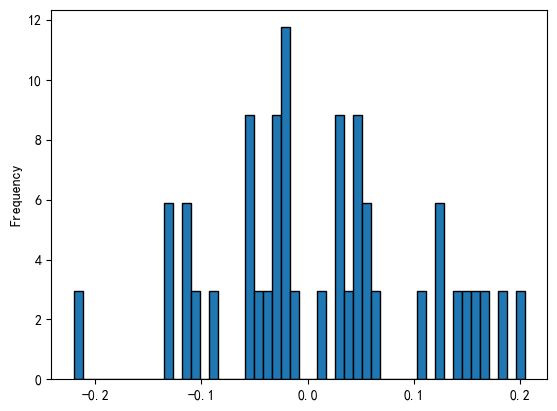

In [21]:
ddwndx['r_return'].plot(kind='hist', bins=50, density=True, edgecolor='black')